In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression




import pandas as pd
import seaborn as sns


In [14]:
# read data

df_predict = pd.read_csv('out/removed_points/20240711_new_model_predictions_output.csv', index_col = 0)

climate = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median',
           'max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
           'frost_days', 'tp', 'snow', 'rain', 'veg_frac', 'target', 'M',
           'circularity_ratio', 'compactness', 'mean_annual_t2m_downsc',
           'cont_permafrost', 'glacier']

df = df_predict[climate]

# LDA with 2 variables


In [15]:
X = df[['sl_median', 'M']]
# X = df[['sl_median', 'snow']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predict probabilities for the positive class (class 1)
y_pred_probs = lda.predict_proba(X_test)[:, 1]

# Predict class labels
y_pred = lda.predict(X_test)


Text(0.5, 1.0, 'slope and M - LDA')

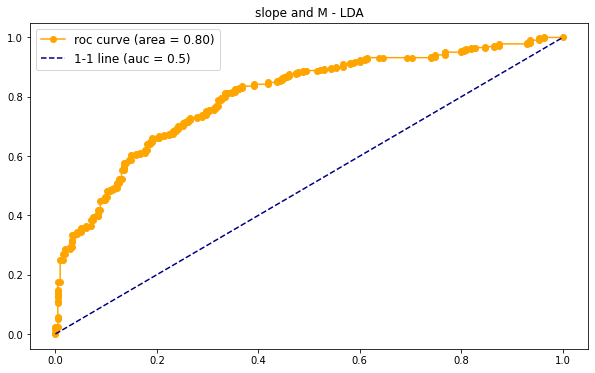

In [16]:
roc = roc_auc_score(y_test, y_pred_probs)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize = (10,6))
plt.plot(fpr, tpr, color = 'orange', marker='o', label = 'roc curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label = '1-1 line (auc = 0.5)')

plt.legend(fontsize=12)
plt.title('slope and M - LDA')

In [17]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[124  91]
 [ 49 274]]


In [18]:
# use the model

# Predict probabilities for the positive class (class 1)
y_pred_probs = lda.predict_proba(X)[:, 1]

# Predict class labels
y_pred = lda.predict(X)



In [19]:
# confusion

result_True = df.target + y_pred # TP = 2, TN = 0

# this is the column to see the "confusuon" situations
# TP = 2, TN = 0
# FP = -1, FN = 1
diff_res = np.where(result_True != 1, result_True, (df.target - y_pred)) 


In [33]:
data = X.copy()

data['diff_res'] = diff_res
data['y_result'] = y_pred
data['probs'] = y_pred_probs

correct_lda = data[data['diff_res'].isin([2, 0])]
wrong_lda = data[data['diff_res'].isin([-1, 1])]


In [34]:
# Get the coefficients for the decision boundary
b0 = lda.intercept_[0]
b1, b2 = lda.coef_[0]

print("Coefficients:", b0, b1, b2)


Coefficients: -3.9400406400333834 0.14106313076486293 -5.404479368024567e-08


In [35]:
# here goes whatever the Y is 
# data = X.copy()

# Generate x values for the decision boundary line
y_values = np.linspace(data.iloc[:, 0].min(), data.iloc[:, 0].max(), 100)
# Calculate corresponding y values using the decision boundary equation
x_values = -(b0 + b1 * y_values) / b2

In [36]:
# X - correct:
# TP = 2, TN = 0
correct = data[data['diff_res'].isin([2, 0])]
wrong = data[data['diff_res'].isin([-1, 1])]


In [57]:
print(len(wrong))

# # 100% - 1806
# # x% - 200

# # x = 213*100/1806

print('percent wrong:', len(wrong)*100/1793)

471
percent wrong: 26.268823201338538


In [38]:

column_name1 = X.columns[1] # x 
column_name0 = X.columns[0] # y

print('x axis:', column_name1)
print('y axis:' ,column_name0)

x axis: M
y axis: sl_median


Text(0.5, 1.0, 'predicted probability (LDA)')

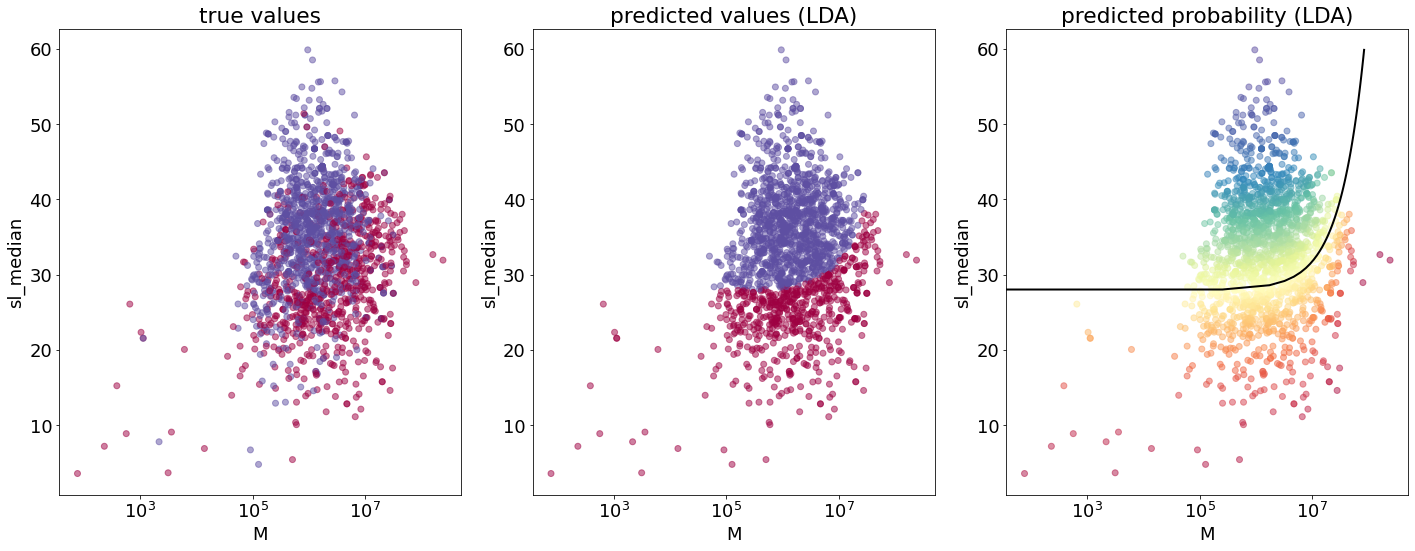

In [39]:
# plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(20, 8), layout = 'tight')

mosaic = fig.subplot_mosaic('''
                            abc
                            ''')

mosaic['a'].scatter(x = data.iloc[:, 1], y = data.iloc[:, 0], c = df.target, alpha = 0.5, cmap = 'Spectral')
mosaic['b'].scatter(x = data.iloc[:, 1], y = data.iloc[:, 0], c = y_pred, alpha = 0.5, cmap = 'Spectral')
mosaic['c'].scatter(x = data.iloc[:, 1], y = data.iloc[:, 0], c = data.probs, alpha = 0.5, cmap = 'Spectral')



# mosaic['c'].scatter(x = correct.M, y = correct.sl_median, c = correct.probs, cmap = 'Spectral', alpha = 0.5, marker='v')
# mosaic['c'].scatter(x = wrong.M, y = wrong.sl_median, c = wrong.probs, alpha = 0.5, cmap = 'Spectral')




mosaic['c'].plot(x_values, y_values, color='black', linewidth=2)


mosaic['a'].set_xscale('log')
mosaic['b'].set_xscale('log')
mosaic['c'].set_xscale('log')

# # mosaic['a'].set_yscale('log')
# # mosaic['b'].set_yscale('log')
# # mosaic['c'].set_yscale('log')


mosaic['a'].set_ylabel(column_name0)
mosaic['b'].set_ylabel(column_name0)
mosaic['c'].set_ylabel(column_name0)

mosaic['a'].set_xlabel(column_name1)
mosaic['b'].set_xlabel(column_name1)
mosaic['c'].set_xlabel(column_name1)

mosaic['a'].set_title('true values')
mosaic['b'].set_title('predicted values (LDA)')
mosaic['c'].set_title('predicted probability (LDA)')

# plt.savefig('out/LDA_classification_test.png', dpi = 300, bbox_inches = 'tight')

# catboost

In [43]:
cat_data = df_predict

correct_cat = cat_data[cat_data['diff_res'].isin([2, 0])]
wrong_cat = cat_data[cat_data['diff_res'].isin([-1, 1])]


In [58]:
print(len(wrong_cat))

# # 100% - 1806
# # x% - 200

# # x = 213*100/1806

print('percent wrong:', 200*100/1793)

200
percent wrong: 11.154489682097044


In [48]:
cat_X = cat_data[['sl_median', 'M','target']]


column_name1 = cat_X.columns[1] # x 
column_name0 = cat_X.columns[0] # y

print('x axis:', column_name1)
print('y axis:' ,column_name0)

x axis: M
y axis: sl_median


Text(0.5, 1.0, 'predicted probability (cat)')

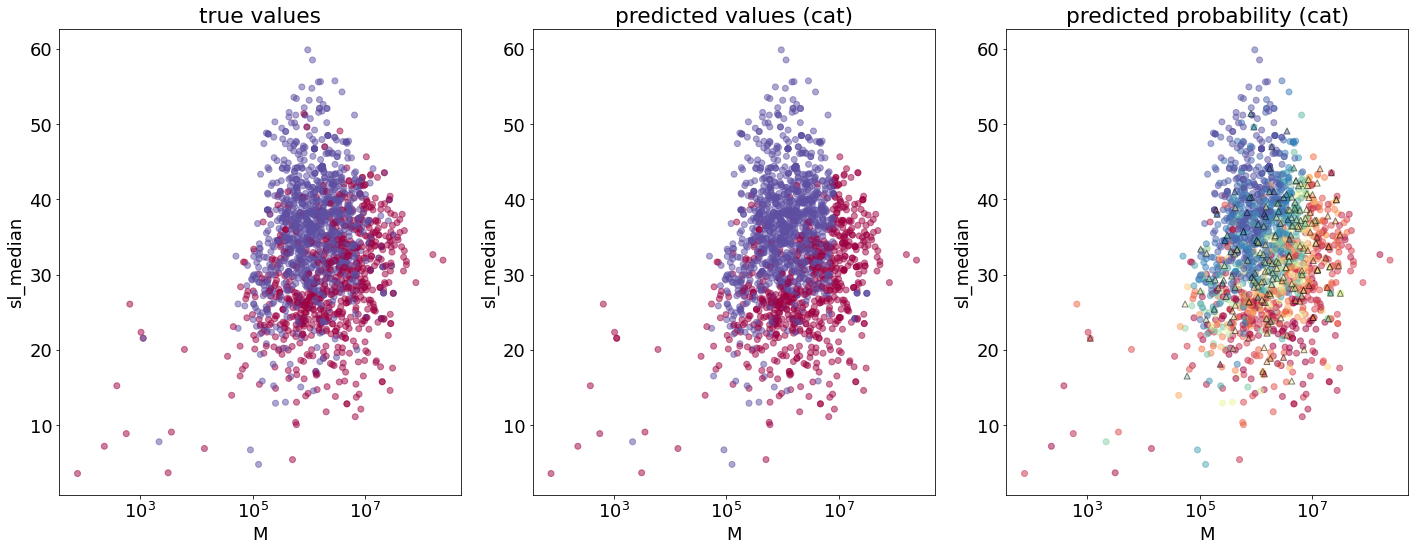

In [49]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(20, 8), layout = 'tight')

mosaic = fig.subplot_mosaic('''
                            abc
                            ''')

mosaic['a'].scatter(x = cat_X.iloc[:, 1], y = cat_X.iloc[:, 0], c = cat_data.target, alpha = 0.5, cmap = 'Spectral')
mosaic['b'].scatter(x = cat_X.iloc[:, 1], y = cat_X.iloc[:, 0], c = cat_data.y_result, alpha = 0.5, cmap = 'Spectral')
# mosaic['c'].scatter(x = cat_X.iloc[:, 1], y = cat_X.iloc[:, 0], c = cat_data.y_result_probs, alpha = 0.5, cmap = 'Spectral')

mosaic['c'].scatter(x = correct_cat.M, y = correct_cat.sl_median, c = correct_cat.y_result_probs, cmap = 'Spectral', alpha = 0.5)
mosaic['c'].scatter(x = wrong_cat.M, y = wrong_cat.sl_median, c = wrong_cat.y_result_probs, edgecolor = 'black', alpha = 0.5,  marker='^', cmap = 'Spectral')



# mosaic['c'].plot(x_values, y_values, color='black', linewidth=2)


mosaic['a'].set_xscale('log')
mosaic['b'].set_xscale('log')
mosaic['c'].set_xscale('log')

# # mosaic['a'].set_yscale('log')
# # mosaic['b'].set_yscale('log')
# # mosaic['c'].set_yscale('log')


mosaic['a'].set_ylabel(column_name0)
mosaic['b'].set_ylabel(column_name0)
mosaic['c'].set_ylabel(column_name0)

mosaic['a'].set_xlabel(column_name1)
mosaic['b'].set_xlabel(column_name1)
mosaic['c'].set_xlabel(column_name1)

mosaic['a'].set_title('true values')
mosaic['b'].set_title('predicted values (cat)')
mosaic['c'].set_title('predicted probability (cat)')

# plt.savefig('out/LDA_classification_test.png', dpi = 300, bbox_inches = 'tight')

# plot together: 

- (a) 3 panels: true value (slope vs M) 
- (b) predicted probabilities with LDA + line 
- (c) predicted ptobabilities with catboost + line (dashed) 


In [51]:
cat_X1 = cat_X[cat_X.target==1]
cat_X0 = cat_X[cat_X.target==0]

ff_color = plt.cm.Set1(1/8)
df_color = plt.cm.Set1(0/8)

colors=[ff_color, df_color]

# colors = ['#FF0000', '#0000FF']  # Red and blue in HEX format
cmap = plt.cm.colors.ListedColormap(colors)


/Users/varyabazilova/opt/anaconda3/envs/project1/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/varyabazilova/opt/anaconda3/envs/project1/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/varyabazilova/opt/anaconda3/envs/project1/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


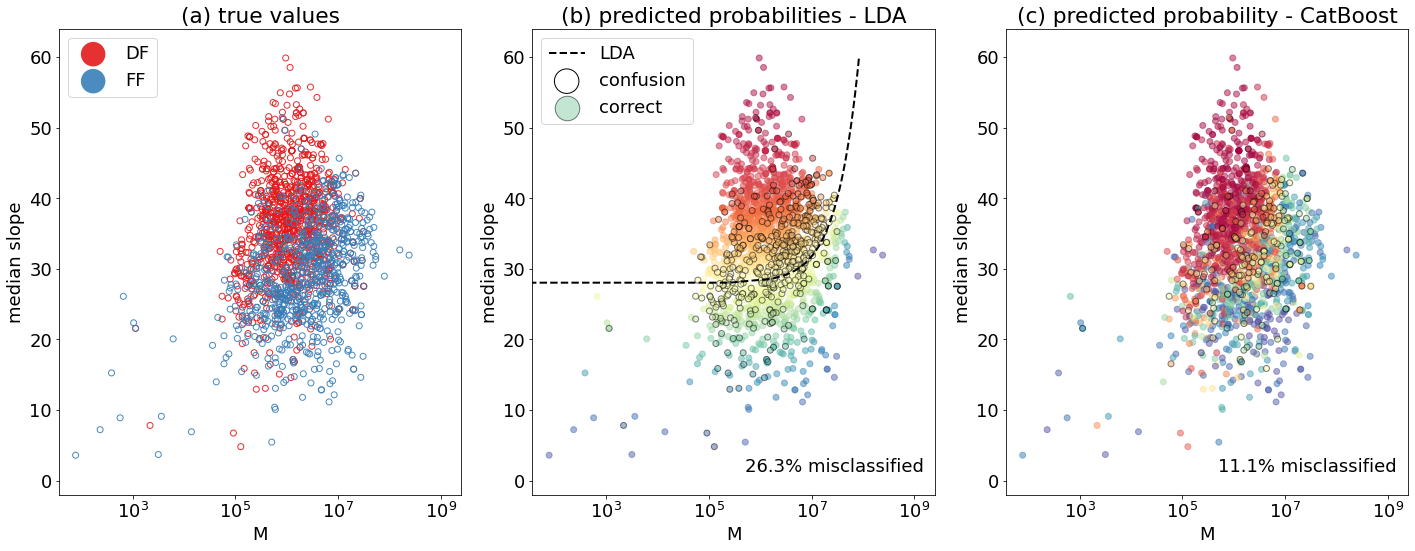

In [69]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(20, 8), layout = 'tight')

mosaic = fig.subplot_mosaic('''
                            abc
                            ''')
cmap = plt.cm.Spectral_r

# true values
mosaic['a'].scatter(x = cat_X1.iloc[:, 1], y = cat_X1.iloc[:, 0], edgecolor = df_color, facecolor = 'none', alpha = 0.9)#, c = cat_data.target, cmap = colors)
mosaic['a'].scatter(x = cat_X0.iloc[:, 1], y = cat_X0.iloc[:, 0], edgecolor = ff_color, facecolor = 'none', alpha = 0.9)# c = cat_data.target, cmap = colors)

# probabilities
# mosaic['b'].scatter(x = data.iloc[:, 1], y = data.iloc[:, 0], c = y_pred_probs, alpha = 0.5, cmap = 'Spectral_r')
mosaic['b'].scatter(x = correct.M, y = correct.sl_median, c = correct.probs, cmap = cmap, alpha = 0.5, vmin=0, vmax=1)
mosaic['b'].scatter(x = wrong.M, y = wrong.sl_median, c = wrong.probs, edgecolor = 'black', alpha = 0.5,  marker='o', cmap = cmap, vmin=0, vmax=1)


# mosaic['c'].scatter(x = cat_X.iloc[:, 1], y = cat_X.iloc[:, 0], c = cat_data.y_result, alpha = 0.5, cmap = 'Spectral_r')
mosaic['c'].scatter(x = correct_cat.M, y = correct_cat.sl_median, c = correct_cat.y_result_probs, cmap = cmap, alpha = 0.5, vmin=0, vmax=1)
mosaic['c'].scatter(x = wrong_cat.M, y = wrong_cat.sl_median, c = wrong_cat.y_result_probs, edgecolor = 'black', alpha = 0.5,  marker='o', cmap = cmap, vmin=0, vmax=1)

# LDA line 
mosaic['b'].plot(x_values, y_values, color='black', linestyle = '--', linewidth=2,  label = 'LDA')
# mosaic['c'].plot(x_values, y_values, color='black', linestyle = '--', linewidth=2)
# mosaic['a'].plot(x_values, y_values, color='black', linestyle = '--', linewidth=2, label = 'LDA')


mosaic['a'].set_xscale('log')
mosaic['b'].set_xscale('log')
mosaic['c'].set_xscale('log')

mosaic['a'].set_ylabel('median slope')
mosaic['b'].set_ylabel('median slope')
mosaic['c'].set_ylabel('median slope')

mosaic['a'].set_xlabel(column_name1)
mosaic['b'].set_xlabel(column_name1)
mosaic['c'].set_xlabel(column_name1)

mosaic['a'].set_title('(a) true values')
mosaic['b'].set_title('(b) predicted probabilities - LDA')
mosaic['c'].set_title('(c) predicted probability - CatBoost')



# lims
mosaic['a'].set_xlim(0, 2.5*10e8)
mosaic['a'].set_ylim(-2,64)

mosaic['b'].set_xlim(0,2.5*10e8)
mosaic['b'].set_ylim(-2,64)

mosaic['c'].set_xlim(0,2.5*10e8)
mosaic['c'].set_ylim(-2,64)


# legend for the plot: 
# # legend:
mosaic['a'].scatter([-10e8],[-60], marker='o', edgecolor='none',facecolor = df_color, alpha = 0.9, s=60*10, label = 'DF')
mosaic['a'].scatter([-10e8],[-60], marker='o', edgecolor='none',facecolor = ff_color, alpha = 0.9, s=60*10, label = 'FF')


mosaic['b'].scatter([-10e8],[-60], marker='o', edgecolor='black',facecolor = 'none', s=60*10, label = 'confusion')
mosaic['b'].scatter([-10e8],[-60], marker='o', edgecolor='black',facecolor = plt.cm.Spectral(6/8), alpha = 0.5, s=60*10, label = 'correct')

mosaic['a'].legend(loc = 'upper left')
mosaic['b'].legend(loc = 'upper left')



mosaic['b'].text(0.75, 0.08, "26.3% misclassified", transform=mosaic['b'].transAxes, fontsize=18, verticalalignment='top', horizontalalignment='center')

mosaic['c'].text(0.75, 0.08, "11.1% misclassified", transform=mosaic['c'].transAxes, fontsize=18, verticalalignment='top', horizontalalignment='center')

# colorbar
# fig.colorbar(plt.cm.ScalarMappable(cmap = 'Spectral_r'), ax=mosaic['c'])

# plt.savefig('out/removed_points/comparison_with_lda.png', dpi = 300, bbox_inches = 'tight')




